# Target Audience for Direct Marketing in Starbucks Rewards Mobile App

This is part 3 of Starbucks capstone project. In this part, I do data preprocessing, clustering and validation. 

See `1_Starbucks_cleaning.ipynb`, `2_Starbucks_eda.ipynb` and `4_Starbucks_refinement.ipynb` for more information on earlier steps.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import time

In [2]:
customers = pd.read_csv('data/starbucks_customer_level.csv', sep=';')

In [3]:
customers.head()

,gender,age,person,became_member_on,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,avg_reward_size,avg_bogo_size,avg_discount_size,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017,NaN,20.40,5.0,9,5.0,5.0,...,2.5,0.0,2.5,100.0,40.0,0.0,0.00,100.00,40.0,0.0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017,112000.0,77.01,0.0,3,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018,NaN,14.30,0.0,6,2.0,1.0,...,0.0,0.0,0.0,50.0,0.0,100.0,0.00,0.00,0.0,0.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0,159.27,15.0,7,4.0,4.0,...,7.5,7.5,0.0,100.0,50.0,100.0,66.67,0.00,0.0,100.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017,NaN,4.65,0.0,3,5.0,3.0,...,0.0,0.0,0.0,60.0,0.0,0.0,0.00,66.67,0.0,50.0


# Data Preprocessing

### Dealing with Missing values

In [4]:
# checking how many missing values are in gender and age columns
customers.gender.isna().sum(), customers.age.isna().sum(), customers.income.isna().sum()

(2175, 2175, 2175)

In [5]:
# checking if missing values are in both columns
assert customers[(customers.gender.isna()) & (customers.age.isna()) & (customers.income.isna())].shape[0] == customers.gender.isna().sum()
print(f"there are {customers.gender.isna().sum()} customers ({customers.gender.isna().sum()/customers.shape[0]*100:.1f}%) that have missing values in gender, age and income columns")

there are 2175 customers (12.8%) that have missing values in gender, age and income columns


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 32 columns):
gender                    14825 non-null object
age                       14825 non-null float64
person                    17000 non-null object
became_member_on          17000 non-null int64
income                    14825 non-null float64
total_amount              17000 non-null float64
total_rewarded            17000 non-null float64
transactions_num          17000 non-null int64
offers_received           17000 non-null float64
offers_viewed             17000 non-null float64
offers_completed          17000 non-null float64
bogo_received             17000 non-null float64
bogo_viewed               17000 non-null float64
bogo_completed            17000 non-null float64
discount_received         17000 non-null float64
discount_viewed           17000 non-null float64
discount_completed        17000 non-null float64
informational_received    17000 non-null float64
informational_v

In [7]:
starbucks_imputed = customers.copy()

In [8]:
imputer = SimpleImputer(strategy='median')
imputed = imputer.fit_transform(starbucks_imputed[['age', 'income']])

In [9]:
starbucks_imputed[['age', 'income']] = pd.DataFrame(imputed, columns=['age', 'income'])

In [10]:
#checking results of imputation for age and income columns
starbucks_imputed[starbucks_imputed.gender.isna()][['age','income']].head(1)

,age,income
0,55.0,64000.0


Impute missing values for categorical data - gender - with most frequent data:

In [11]:
values = {'gender': starbucks_imputed.gender.mode()[0]}
starbucks_imputed.fillna(value=values, inplace=True)

In [12]:
#checking results of imputation of categorical data
starbucks_imputed[customers.gender.isna()]['gender'].head(1)

0    M
Name: gender, dtype: object

In [13]:
starbucks_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 32 columns):
gender                    17000 non-null object
age                       17000 non-null float64
person                    17000 non-null object
became_member_on          17000 non-null int64
income                    17000 non-null float64
total_amount              17000 non-null float64
total_rewarded            17000 non-null float64
transactions_num          17000 non-null int64
offers_received           17000 non-null float64
offers_viewed             17000 non-null float64
offers_completed          17000 non-null float64
bogo_received             17000 non-null float64
bogo_viewed               17000 non-null float64
bogo_completed            17000 non-null float64
discount_received         17000 non-null float64
discount_viewed           17000 non-null float64
discount_completed        17000 non-null float64
informational_received    17000 non-null float64
informational_v

Let's summarize above steps in a function:

In [14]:
def deal_with_missing_values(starbucks_engineered, how='impute'):
    '''
    Input:
        starbucks_engineered: dataframe that resulted from engineer_new_features()
        how: 
            'impute' with median values, 
            'drop' missing values 
    Output:
        starbucks_imputed: data frame without missing values
    '''
    starbucks_imputed = starbucks_engineered.copy()

    if how == 'impute':
        imputer = SimpleImputer(strategy='median')
        imputed = imputer.fit_transform(starbucks_engineered[['age', 'income']])
        starbucks_imputed[['age', 'income']] = pd.DataFrame(imputed, columns=['age', 'income'])
        values = {'gender': starbucks_engineered.gender.mode()[0]}
        starbucks_imputed.fillna(value=values, inplace=True)
        
    if how == 'drop':
          starbucks_imputed.dropna(axis=0, inplace=True)
    
    return starbucks_imputed

In [15]:
starbucks_imputed = deal_with_missing_values(customers, how='impute')

In [16]:
starbucks_imputed.head()

,gender,age,person,became_member_on,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,avg_reward_size,avg_bogo_size,avg_discount_size,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr
0,M,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017,64000.0,20.40,5.0,9,5.0,5.0,...,2.5,0.0,2.5,100.0,40.0,0.0,0.00,100.00,40.0,0.0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017,112000.0,77.01,0.0,3,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,M,55.0,38fe809add3b4fcf9315a9694bb96ff5,2018,64000.0,14.30,0.0,6,2.0,1.0,...,0.0,0.0,0.0,50.0,0.0,100.0,0.00,0.00,0.0,0.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0,159.27,15.0,7,4.0,4.0,...,7.5,7.5,0.0,100.0,50.0,100.0,66.67,0.00,0.0,100.0
4,M,55.0,a03223e636434f42ac4c3df47e8bac43,2017,64000.0,4.65,0.0,3,5.0,3.0,...,0.0,0.0,0.0,60.0,0.0,0.0,0.00,66.67,0.0,50.0


### One-Hot Encoding categorical data

In [17]:
starbucks_ohe = starbucks_imputed.copy()

In [18]:
# drop person id from further analysis
starbucks_ohe.drop('person', axis=1, inplace=True)

In [19]:
# I want to turn membership years into categorical feature
starbucks_ohe['became_member_on'] = starbucks_ohe['became_member_on'].astype(str)

In [20]:
categorical_col = starbucks_ohe.columns[(starbucks_ohe.dtypes == 'category') | (starbucks_ohe.dtypes == 'object')]
categorical_col

Index(['gender', 'became_member_on'], dtype='object')

In [21]:
starbucks_ohe = pd.get_dummies(starbucks_ohe, columns=categorical_col)

In [22]:
starbucks_ohe.head()

,age,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,offers_completed,bogo_received,bogo_viewed,...,informational_rr,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
0,55.0,64000.0,20.40,5.0,9,5.0,5.0,2.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,1,0
1,55.0,112000.0,77.01,0.0,3,2.0,0.0,0.0,1.0,0.0,...,0.0,1,0,0,0,0,0,0,1,0
2,55.0,64000.0,14.30,0.0,6,2.0,1.0,0.0,1.0,1.0,...,0.0,0,1,0,0,0,0,0,0,1
3,75.0,100000.0,159.27,15.0,7,4.0,4.0,2.0,3.0,3.0,...,100.0,1,0,0,0,0,0,0,1,0
4,55.0,64000.0,4.65,0.0,3,5.0,3.0,0.0,0.0,0.0,...,50.0,0,1,0,0,0,0,0,1,0


In [23]:
starbucks_ohe.shape

(17000, 38)

### Feature Scaling

In [24]:
scaler = StandardScaler().fit(starbucks_ohe) 
starbucks_scaled = scaler.transform(starbucks_ohe)

In [25]:
#checking scaling results on first 5 features
starbucks_scaled.std(axis=0)[:5], starbucks_scaled.mean(axis=0)[:5]

(array([1., 1., 1., 1., 1.]),
 array([-1.27897692e-16, -1.64051779e-16,  1.04700562e-16,  7.61743609e-17,
         5.18278231e-17]))

Note: scaler works as expected - all features were transformed correctly and have mean around 0 and std 1.

### Dimensionality Reduction via PCA

In [26]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(starbucks_scaled)

In [27]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

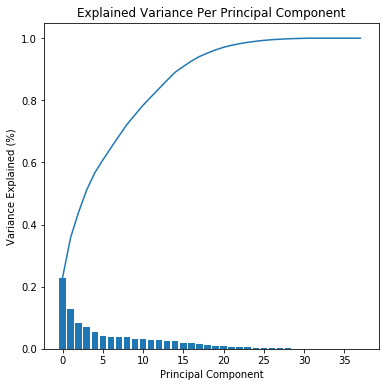

In [28]:
scree_plot(pca)

In [29]:
# how many components together explain about 80% of variance?
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
components_num = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.805])
components_num

11

**Note:** As a rule of thumb, one should keep as many components that together they would explain about 80% of variance.

In [30]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(components_num).fit(starbucks_scaled)
starbucks_pca = pca.transform(starbucks_scaled)

In [31]:
starbucks_pca.shape

(17000, 11)

In [32]:
np.cumsum(pca.explained_variance_ratio_)

array([0.22853214, 0.35769969, 0.44011231, 0.51138956, 0.56619233,
       0.60741794, 0.64664913, 0.68464681, 0.72206155, 0.75333093,
       0.78400096])

# Clustering

In [33]:
# Over a number of different cluster counts...
range_n_clusters = [2, 3, 5, 8, 10, 15]
sum_of_squared_distances = []
since = time.time()

for n_clusters in range_n_clusters:
    cluster_start = time.time()
    print("calculating {} clusters".format(n_clusters))
    # run k-means clustering on the data and...
    clusterer = KMeans(n_clusters=n_clusters, n_init=100, init='k-means++').fit(starbucks_pca)   
    print(f"{n_clusters}: silouhette score: {metrics.silhouette_score(starbucks_pca, clusterer.labels_, metric='euclidean')}")
    # ... compute the average within-cluster distances.
    sum_of_squared_distances.append(clusterer.inertia_)
    print("sum of squared distances:", clusterer.inertia_)
    #print("time for this cluster:", time.time() - cluster_start)

time_elapsed = time.time() - since
print('Clustering complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

calculating 2 clusters
2: silouhette score: 0.2110484319817052
sum of squared distances: 399896.94307398744
calculating 3 clusters
3: silouhette score: 0.17421349787032406
sum of squared distances: 348147.1760208023
calculating 5 clusters
5: silouhette score: 0.1344437585652959
sum of squared distances: 301962.96809248795
calculating 8 clusters
8: silouhette score: 0.11470588245667042
sum of squared distances: 273706.71681210404
calculating 10 clusters
10: silouhette score: 0.1170252714096925
sum of squared distances: 259316.62100658004
calculating 15 clusters
15: silouhette score: 0.11285182288919218
sum of squared distances: 231724.87846742937
Clustering complete in 0m 59s


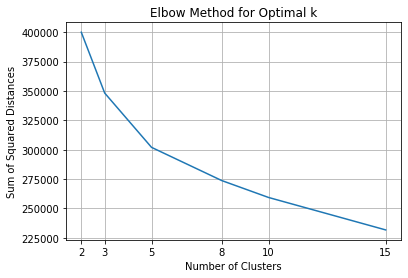

In [34]:
plt.plot(range_n_clusters, sum_of_squared_distances)
plt.xlabel('Number of Clusters')
plt.xticks(range_n_clusters, range_n_clusters)
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.grid();

Note: From elbow plot we can see two potential cluster numbers - 3 and 5, although 3 clusters have higher silouehtte score than 5.

In [35]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions
clusterer = KMeans(n_clusters=3, n_init=100, init='k-means++').fit(starbucks_pca)
print("silhouette score:", metrics.silhouette_score(starbucks_pca, clusterer.labels_, metric='euclidean'))
starbucks_preds = clusterer.predict(starbucks_pca)

silhouette score: 0.17416729087706442


# Model Evaluation

In this step, I inverse the values of Scaler and PCA to interpret clustering results.

In [86]:
def interpret_cluster(cluster_num, df, minmax):
    '''
    Performs inversing the results of PCA and Scaler to allow cluster interpretation
    Input:
        cluster_num: number of clusters that were used to perform clustering
        df: data frame used for clustering
        minmax (bool): condition whetherminmax scaler was used 
    Output:
        results_df: data frame with inversed values for one cluster                
    '''
    pca_inversed = pca.inverse_transform(clusterer.cluster_centers_[cluster_num, :])
    
    if minmax == True:
        scaler_inversed = np.around(scaler.inverse_transform(pca_inversed.reshape(1, -1)), decimals=2)
        results_df = pd.DataFrame(scaler_inversed.ravel(), df.columns)
    else:
        scaler_inversed = np.around(scaler.inverse_transform(pca_inversed), decimals=2)
        results_df = pd.DataFrame(scaler_inversed, df.columns)
    
    return results_df

In [37]:
def create_cluster_df(cluster_num, df, minmax=False):
    '''
    Creates results dataframe for all clusters and compares them with mean values across each column
    Input:
        cluster_num: number of clusters that were used to perform clustering
        df: data frame used for clustering
        minmax (bool): condition whetherminmax scaler was used 
    Output:
        results_df: data frame with cluster results for all clusters                
    '''  

    cluster_df = pd.DataFrame(interpret_cluster(0, df, minmax))
    cluster_df.drop(0, axis=1, inplace=True)

    for i in range(cluster_num):
        cluster_df['cluster_'+str(i+1)] = interpret_cluster(i, df, minmax)
    means = []
    for each in starbucks_ohe.columns:
        mean = round(starbucks_ohe[each].mean(), 2)
        means.append(mean)
    means_df = pd.DataFrame(means, index=cluster_df.index, columns=['means'])
    cluster_df_fin = cluster_df.merge(means_df, on=cluster_df.index)
    cluster_df_fin.index = cluster_df_fin.key_0
    cluster_df_fin.drop('key_0', axis=1, inplace=True)

    return cluster_df_fin

In [38]:
cluster_df = create_cluster_df(3, starbucks_ohe) 
cluster_df

,cluster_1,cluster_2,cluster_3,means
key_0,,,,
age,52.95,54.22,56.67,54.47
income,61217.38,64168.60,71394.38,65225.24
total_amount,38.91,115.58,179.05,104.44
total_rewarded,-0.08,4.80,13.64,5.58
transactions_num,5.94,9.86,9.51,8.17
offers_received,4.35,4.55,4.61,4.49
offers_viewed,2.81,3.39,3.74,3.27
offers_completed,0.02,1.62,2.21,1.16
bogo_received,1.78,1.29,2.28,1.79


Generate plots to visualize clustering results:

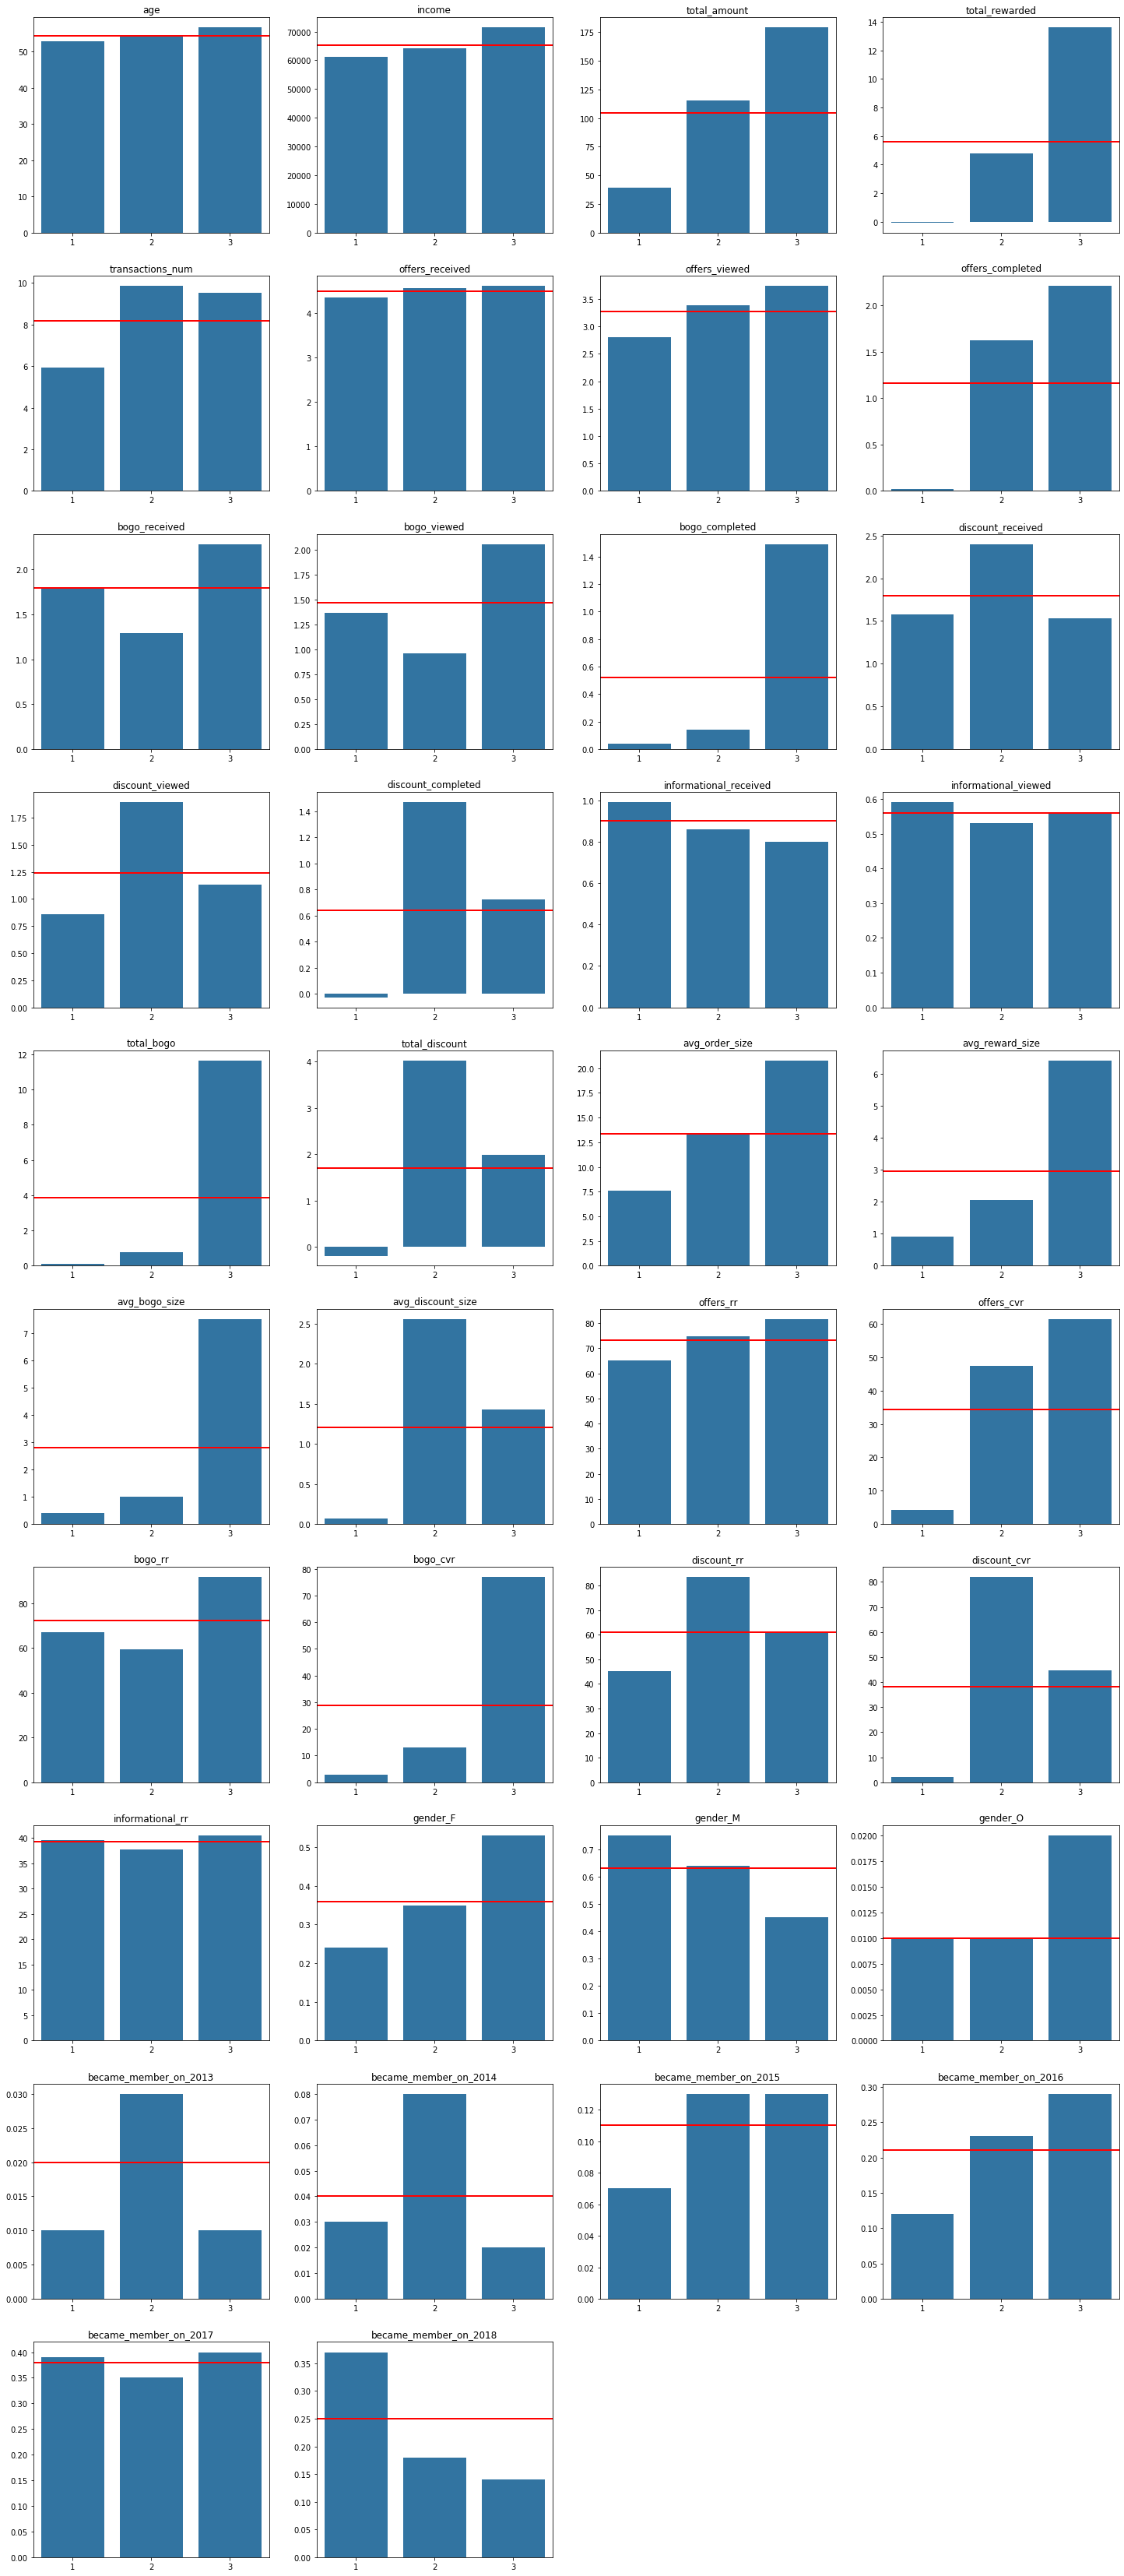

In [39]:
number_subplots = len(cluster_df.T.columns)
base_color = sns.color_palette()[0]
plt.figure(figsize=(25, 60));

for i, each in enumerate(cluster_df.T.columns):
    ax = plt.subplot(int(number_subplots/4)+1,4,i+1)
    sns.barplot(y=each, x=['1', '2', '3'], data=cluster_df.T.iloc[:-1, :], color=base_color);
    plt.title(f"{each}");
    ax.axhline(y=cluster_df.T[each][-1], linewidth=2, color='r');
    plt.ylabel("");

# Validation

Since clustering techniques don't have good metrics like supervised modeling to evaluate the modeling results, I will rely on results validation through visualization of segments.

In [40]:
starbucks_predicted = starbucks_imputed.copy()
starbucks_predicted['segments'] = starbucks_preds

In [63]:
# assign specific labels based on key characteristics automatically:
labels = []
for i in range(len(starbucks_predicted['segments'].unique())):
    subset = starbucks_predicted[starbucks_predicted['segments'] == i]
    if (subset.bogo_cvr.mean() < 10) & (subset.discount_cvr.mean() < 10):
        print(i+1, "disinterested")
        labels.append(str(i+1)+"_disinterested")
    elif subset.bogo_cvr.mean() > subset.discount_cvr.mean():
        print(i+1, "bogo-type")
        labels.append(str(i+1)+"_bogo-type")
    elif subset.discount_cvr.mean() > subset.bogo_cvr.mean():
        print(i+1, "discount-type")
        labels.append(str(i+1)+"_discount-type")

1 disinterested
2 discount-type
3 bogo-type


In [64]:
# encode the segments with labels
# note: LabelEncoder sorts labels in alphabetic order, which is bad for us. 
# Because we have clusters in particular order and want to do inverse_transform, we need to start labels with numbers
le = LabelEncoder()
le.fit(labels)
starbucks_predicted['segments_labeled'] = le.inverse_transform(starbucks_preds)

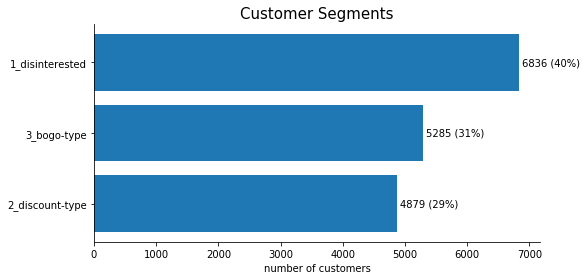

In [65]:
fig = plt.figure(figsize=(8, 4));
num_clusters = 3
yticks = starbucks_predicted['segments_labeled'].value_counts(ascending=True)
plt.barh(range(num_clusters), yticks, tick_label=yticks.index);
plt.title("Customer Segments", fontsize=15);
plt.xlabel("number of customers")
for i, v in enumerate(yticks):
    count = str(v)+" ("+str(round(v/starbucks_predicted.shape[0]*100))+"%)"
    plt.text(v+50, i, count, va='center');
sns.despine(fig);



## Metrics

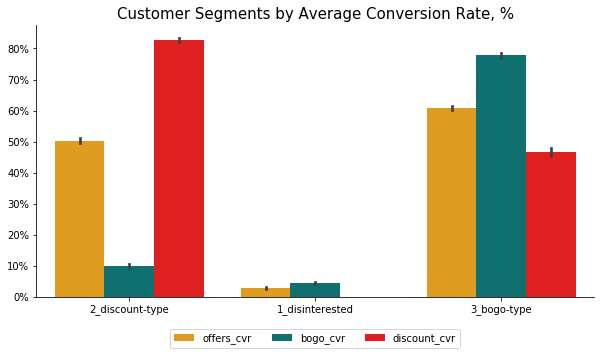

In [66]:
cols = ['offers_cvr', 'bogo_cvr', 'discount_cvr']
fig, ax = plt.subplots(figsize=(10, 5))

tidy = starbucks_predicted.melt(id_vars='segments_labeled', value_vars=cols).rename(columns=str.title)
barplot = sns.barplot(x='Segments_Labeled', y='Value', hue='Variable', data=tidy, ax=ax, palette=['orange', 'teal', 'red']);
plt.xlabel("");
plt.ylabel("");
plt.title("Customer Segments by Average Conversion Rate, %", fontsize=15);
sns.despine(fig);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3);

Note: From the above plot, we can see the three main customer segments - "discount type" with the highest conversion rate on discounts (as predicted), "bogo type" having high conversion rates on bogo and less so on discounts (with bogo being much higher) and "disinterested" that have very low conversion rates on average.

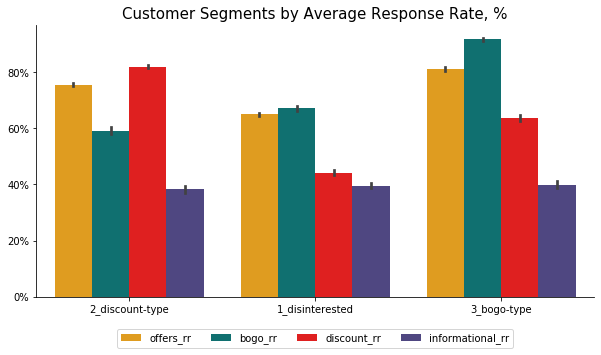

In [67]:
cols = ['offers_rr', 'bogo_rr', 'discount_rr', 'informational_rr']
fig, ax = plt.subplots(figsize=(10, 5))

tidy = starbucks_predicted.melt(id_vars='segments_labeled', value_vars=cols).rename(columns=str.title)
barplot = sns.barplot(x='Segments_Labeled', y='Value', hue='Variable', data=tidy, ax=ax, palette=['orange', 'teal', 'red', 'darkslateblue']);
plt.xlabel("");
plt.ylabel("");
plt.title("Customer Segments by Average Response Rate, %", fontsize=15);
sns.despine(fig);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4);

## Profile

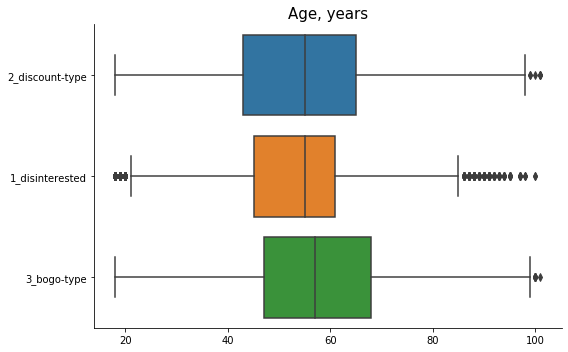

In [80]:
fig, ax = plt.subplots(figsize=(8, 5));
sns.boxplot(x='age', y='segments_labeled', data=starbucks_predicted, ax=ax);
plt.title("Age, years", fontsize=15);
plt.xlabel("");
plt.ylabel("");
sns.despine(fig);
plt.tight_layout();

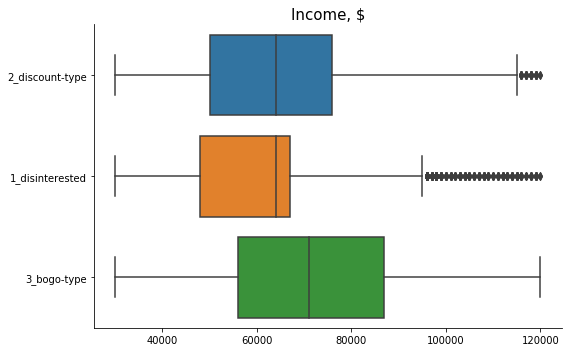

In [81]:
fig, ax = plt.subplots(figsize=(8, 5));
sns.boxplot(x='income', y='segments_labeled', data=starbucks_predicted, ax=ax);
plt.title("Income, $", fontsize=15);
plt.xlabel("");
plt.ylabel("");
sns.despine(fig);
plt.tight_layout();

In [82]:
# to plot became_member_on and gender features we need dummies 
# right now we don't have these columns in starbucks_predicted
# because we copied from starbucks_imputed
# add columns from starbucks_ohe
cols = ['became_member_on_2013','became_member_on_2014', 
        'became_member_on_2015','became_member_on_2016', 
        'became_member_on_2017','became_member_on_2018', 
        'gender_F', 'gender_M', 'gender_O']

for each in cols:
    starbucks_predicted[each] = starbucks_ohe[each]

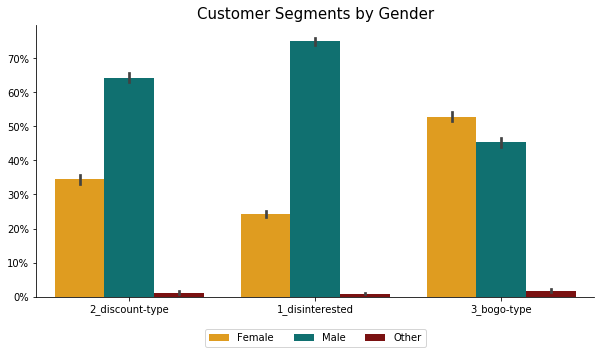

In [83]:
fig, ax = plt.subplots(figsize=(10, 5))
tidy = starbucks_predicted.melt(id_vars='segments_labeled', value_vars=['gender_F', 'gender_M','gender_O']).rename(columns=str.title)
#change ugly labels 'gender_F' to 'Female', etc
for oldlabel, newlabel in zip(['gender_F', 'gender_M','gender_O'], ['Female', 'Male', 'Other']):
    tidy.Variable = [v.replace(oldlabel, newlabel) for v in tidy.Variable.values]

barplot = sns.barplot(x='Segments_Labeled', y='Value', hue='Variable', data=tidy, ax=ax, palette=['orange', 'teal', 'darkred']);
plt.xlabel("");
plt.ylabel("");
plt.title("Customer Segments by Gender", fontsize=15);
sns.despine(fig);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3);

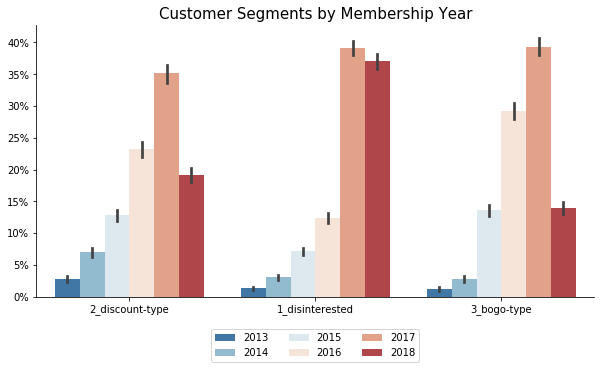

In [84]:
cols = ['became_member_on_2013','became_member_on_2014', 
        'became_member_on_2015','became_member_on_2016', 
        'became_member_on_2017','became_member_on_2018']
fig, ax = plt.subplots(figsize=(10, 5))

tidy = starbucks_predicted.melt(id_vars='segments_labeled', value_vars=cols).rename(columns=str.title)
#change ugly labels 'became_member_on_2013' to '2013', etc
for col, year in zip(cols, [str(x) for x in range(2013, 2019)]):
    tidy.Variable = [v.replace(col, year) for v in tidy.Variable.values]
    
barplot = sns.barplot(x='Segments_Labeled', y='Value', hue='Variable', data=tidy, ax=ax, palette='RdBu_r');
plt.xlabel("");
plt.ylabel("");
plt.title("Customer Segments by Membership Year", fontsize=15);
sns.despine(fig);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3);

## Spending Habits

In [68]:
def boxplot_by_segments(col, title):
    '''
    Input: 
        col: column name as string
        title: plot's title as string
    Output: none
    '''
    fig = plt.figure(figsize=(8, 5));
    sns.boxplot(x='segments_labeled', y=col, data=starbucks_predicted);
    plt.title(title, fontsize=15);
    plt.xlabel("");
    plt.ylabel("");
    sns.despine(fig);
    plt.tight_layout();

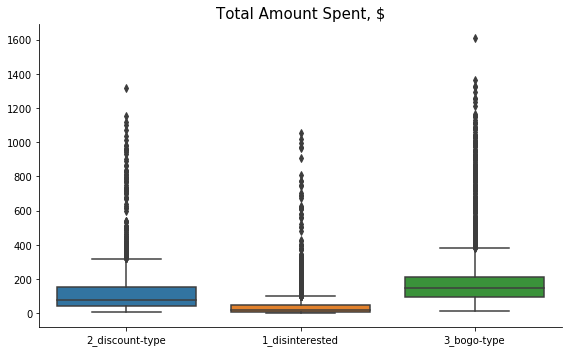

In [69]:
boxplot_by_segments('total_amount', "Total Amount Spent, $")

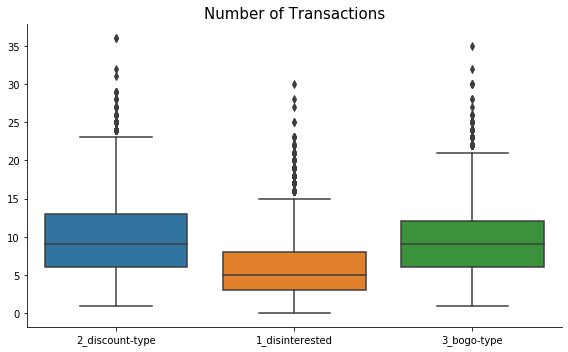

In [70]:
boxplot_by_segments('transactions_num', "Number of Transactions")

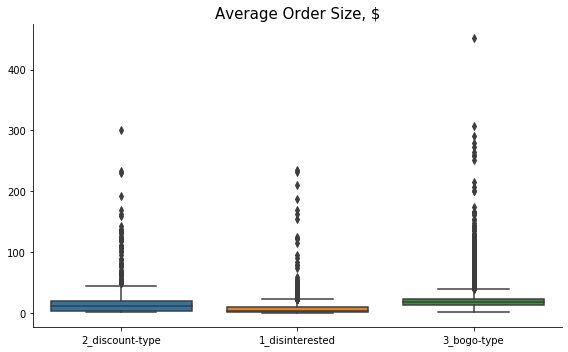

In [71]:
boxplot_by_segments('avg_order_size', "Average Order Size, $")

## Rewards Patterns

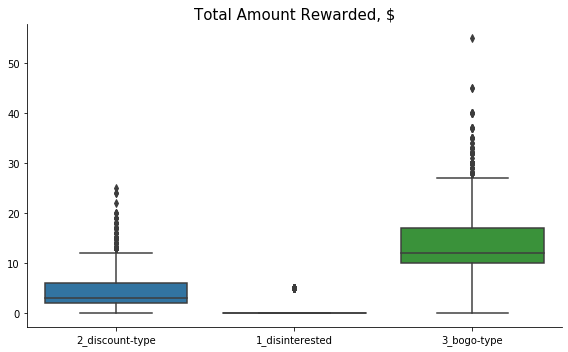

In [72]:
boxplot_by_segments('total_rewarded', "Total Amount Rewarded, $")

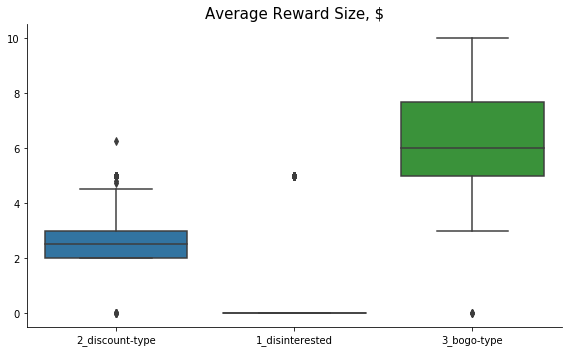

In [73]:
boxplot_by_segments('avg_reward_size', "Average Reward Size, $")

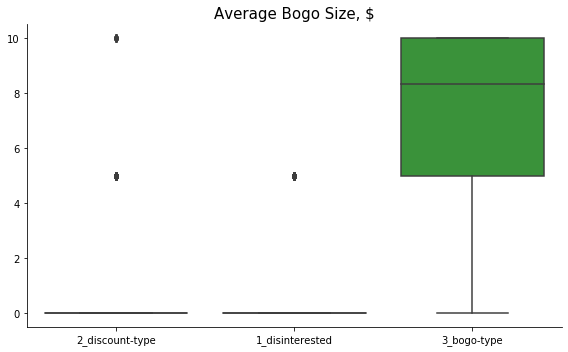

In [74]:
boxplot_by_segments('avg_bogo_size', "Average Bogo Size, $")

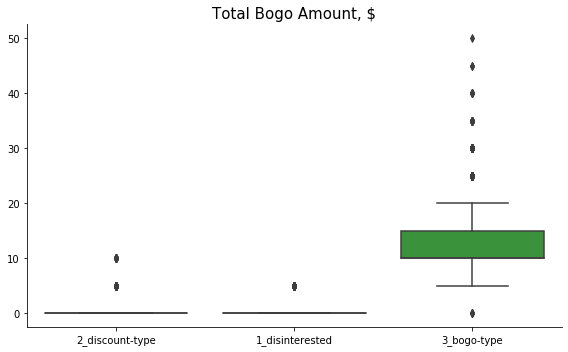

In [75]:
boxplot_by_segments('total_bogo', "Total Bogo Amount, $")

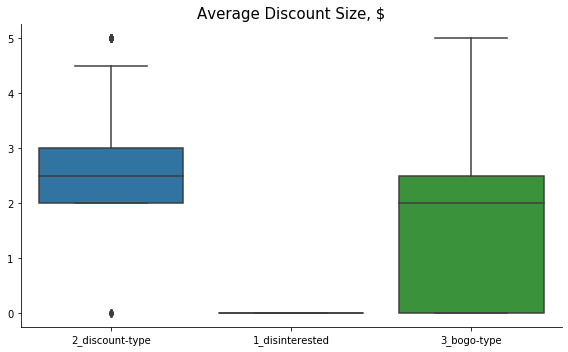

In [76]:
boxplot_by_segments('avg_discount_size', "Average Discount Size, $")

In [77]:
# calcualte mean of 'avg_discount_size' for each of the three main segments:
for each in labels:
    subset = starbucks_predicted[starbucks_predicted.segments_labeled == each]
    print(f"{each}: {subset.avg_discount_size.mean():.1f}$")

1_disinterested: 0.0$
2_discount-type: 2.6$
3_bogo-type: 1.5$


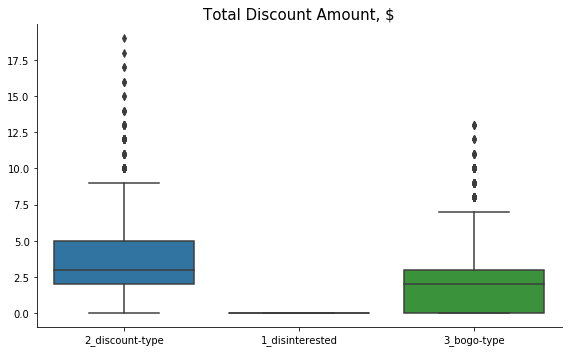

In [78]:
boxplot_by_segments('total_discount', "Total Discount Amount, $")

# Conclusion:

Having segmented data into 3 groups, we now have better insight into Starbucks rewards user base. There are clearly customer groups who like either bogos or discounts, or hate both. The clustering results would allow the company to better target audience with tailored offers in the next marketing campaign. 

To arrive at this solution, I performed the full analysis cycle - cleaning and preprocessing the data, dealing with missing values, feature engineering, feature scaling, one hot encoding, dimensionality reduction and clustering.

# Acknowledgement:

When deciding which metrics to use, I relied on the following sources:

* Farris, P., Bendle, N., Pfeifer, Ph., Reibstein, D. (2016): Marketing Metrics: The Manager's Guide to Measuring Marketing Performance, 3rd Edition. Pearson Education, Inc. Chapter 8 "Promotions", pp. 271-293.

* Promotional Effectiveness Metrics & Email Capture Benchmarks Across 10 Ecommerce Industries [2019 Report], https://www.bigcommerce.com/blog/promotional-marketing/#what-is-promotional-marketing

* Lesko, Brandon (May 2019): "How to track and measure direct mail campaigns", The Mail Shark,
https://www.themailshark.com/resources/guides/how-to-track-measure-direct-mail/

